In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from src.model import *
from src.mtg_df_prep import *


In [2]:
data_dir = '/home/jovyan/data/art/'
target_size = (224, 224)
batch_size = 8


In [3]:
cards = load_color_data(mono=True)

In [4]:
cards.set_type.unique()

array(['expansion', 'promo', 'core', 'draft_innovation', 'commander',
       'starter', 'duel_deck', 'funny', 'token', 'masterpiece',
       'planechase', 'masters', 'spellbook', 'box', 'vanguard',
       'archenemy', 'from_the_vault', 'memorabilia', 'treasure_chest',
       'premium_deck'], dtype=object)

In [5]:
# df = cards[cards.set_type.isin(['core'])]
df = cards[cards.set.isin(['m10'])]
df.set.unique()

array(['m10'], dtype=object)

In [6]:
df = generate_flow_df(df)
train_df, test_df = train_test_split(df, test_size=0.2)


In [7]:
# Instantiate Image Data Generators
train_idg = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.20
)
test_idg = ImageDataGenerator(rescale=1/255.0)
        
train_gen = train_idg.flow_from_dataframe(
    dataframe=train_df,
    directory = data_dir,
    x_col='path',
    y_col='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=19
)

valid_gen = train_idg.flow_from_dataframe(
    dataframe=train_df,
    directory=data_dir,
    x_col='path',
    y_col='target',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=19
)

test_gen = test_idg.flow_from_dataframe(
    dataframe=test_df,
    directory=data_dir,
    x_col='path',
    target_size=target_size,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 94 validated image filenames belonging to 6 classes.
Found 23 validated image filenames belonging to 6 classes.
Found 30 validated image filenames.


/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [8]:
input_shape = target_size + (3,)
model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
model.layers

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
dropout (Dropout)            (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0

In [11]:
history = model.fit(
    train_gen,
    validation_data=train_gen,
    steps_per_epoch=train_gen.n//train_gen.batch_size,
    validation_steps=valid_gen.n//valid_gen.batch_size,
    epochs=10
)

Epoch 1/10
11/11 [==============================] - 4s 323ms/step - loss: 4.3300 - accuracy: 0.1469 - val_loss: 1.8416 - val_accuracy: 0.2500
Epoch 2/10
11/11 [==============================] - 3s 281ms/step - loss: 1.8155 - accuracy: 0.2995 - val_loss: 1.8840 - val_accuracy: 0.1250
Epoch 3/10
11/11 [==============================] - 3s 278ms/step - loss: 1.8055 - accuracy: 0.2619 - val_loss: 1.8800 - val_accuracy: 0.1875
Epoch 4/10
11/11 [==============================] - 3s 278ms/step - loss: 1.8014 - accuracy: 0.2468 - val_loss: 1.6254 - val_accuracy: 0.4375
Epoch 5/10
11/11 [==============================] - 3s 287ms/step - loss: 1.7438 - accuracy: 0.2901 - val_loss: 1.5862 - val_accuracy: 0.3750
Epoch 6/10
11/11 [==============================] - 3s 301ms/step - loss: 1.4896 - accuracy: 0.4545 - val_loss: 1.4368 - val_accuracy: 0.5625
Epoch 7/10
11/11 [==============================] - 3s 285ms/step - loss: 1.4996 - accuracy: 0.3820 - val_loss: 1.6855 - val_accuracy: 0.2500
Epoch 

In [12]:
score = model.evaluate(valid_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


3/3 [==============================] - 0s 115ms/step - loss: 1.7853 - accuracy: 0.2609
Test loss: 1.7853296995162964
Test accuracy: 0.260869562625885


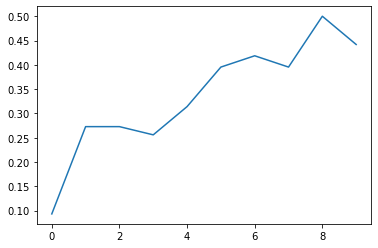

In [13]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['accuracy'])
plt.show()

In [14]:
filenames = test_gen.filenames
predict = model.predict(test_gen, steps=len(filenames))
pred = ['CWUBRG'[c] for c in predict.argmax(axis=1)]
true = test_df[test_df['path'].isin(test_gen.filenames)].explode('target')['target']

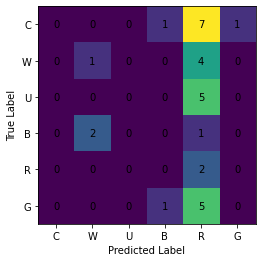

In [15]:
plot_conf_matrix(true, pred)

In [16]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,3.266134,0.093023,1.841639,0.2500
1,1.841311,0.272727,1.884004,0.1250
2,1.808056,0.272727,1.880043,0.1875
3,1.812690,0.255814,1.625404,0.4375
4,1.685589,0.313953,1.586164,0.3750
5,1.566413,0.395349,1.436774,0.5625
6,1.548473,0.418605,1.685459,0.2500
7,1.477982,0.395349,1.829890,0.1875
8,1.424292,0.500000,1.372420,0.5625
9,1.453482,0.441860,1.626432,0.3125
